# K-Means Clustering for Cancer Risk Analysis
Unsupervised learning to discover patient risk patterns

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load and Prepare Data

In [2]:
# Load cleaned cancer data
df = pd.read_csv('cleaned_cancer_data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2000, 20)


,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,Fruit_Veg_Intake,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,Breast,68,0,7,2,8,0,5,3,7,4,6,3,1,0,0,0.398696,28.0,5,Medium
1,Prostate,74,1,8,9,8,0,0,3,7,1,3,3,0,0,5,0.424299,25.4,9,Medium
2,Skin,55,1,7,10,7,0,3,3,4,1,8,10,0,0,6,0.605082,28.6,2,Medium
3,Colon,61,0,6,2,2,0,6,2,4,6,4,8,0,0,8,0.318449,32.1,7,Low
4,Lung,67,1,10,7,4,0,6,3,10,9,10,9,0,0,5,0.524358,25.1,2,Medium


In [3]:
# Select numerical features (excluding target)
features = ['Age', 'Smoking', 'Alcohol_Use', 'Obesity', 'Family_History',
            'Diet_Red_Meat', 'Diet_Salted_Processed', 'Fruit_Veg_Intake',
            'Physical_Activity', 'Air_Pollution', 'Occupational_Hazards',
            'BMI', 'Physical_Activity_Level', 'Overall_Risk_Score']

X = df[features]
print(f"Features selected: {len(features)}")

Features selected: 14


In [4]:
# Standardize features (essential for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Features standardized")

✓ Features standardized


## Find Optimal Number of Clusters (Elbow Method)

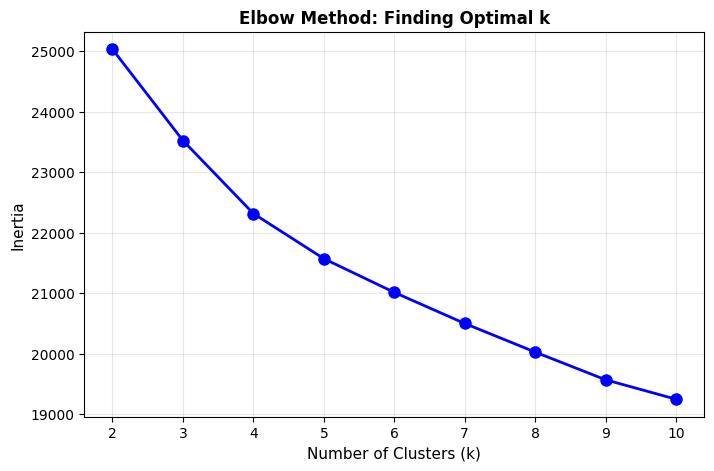

In [5]:
# Calculate inertia for different k values
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow Method: Finding Optimal k', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

## Apply K-Means Clustering

In [6]:
# Apply K-means with k=4 (optimal for risk stratification)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df['Cluster'] = clusters
print(f"✓ Clustering complete with k={optimal_k}")
print(f"Cluster distribution:\n{df['Cluster'].value_counts().sort_index()}")

✓ Clustering complete with k=4
Cluster distribution:
Cluster
0    618
1    499
2    518
3    365
Name: count, dtype: int64


## Dimensionality Reduction for Visualization

In [7]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

Variance explained by PC1: 15.73%
Variance explained by PC2: 11.11%
Total variance explained: 26.84%


## Visualizations

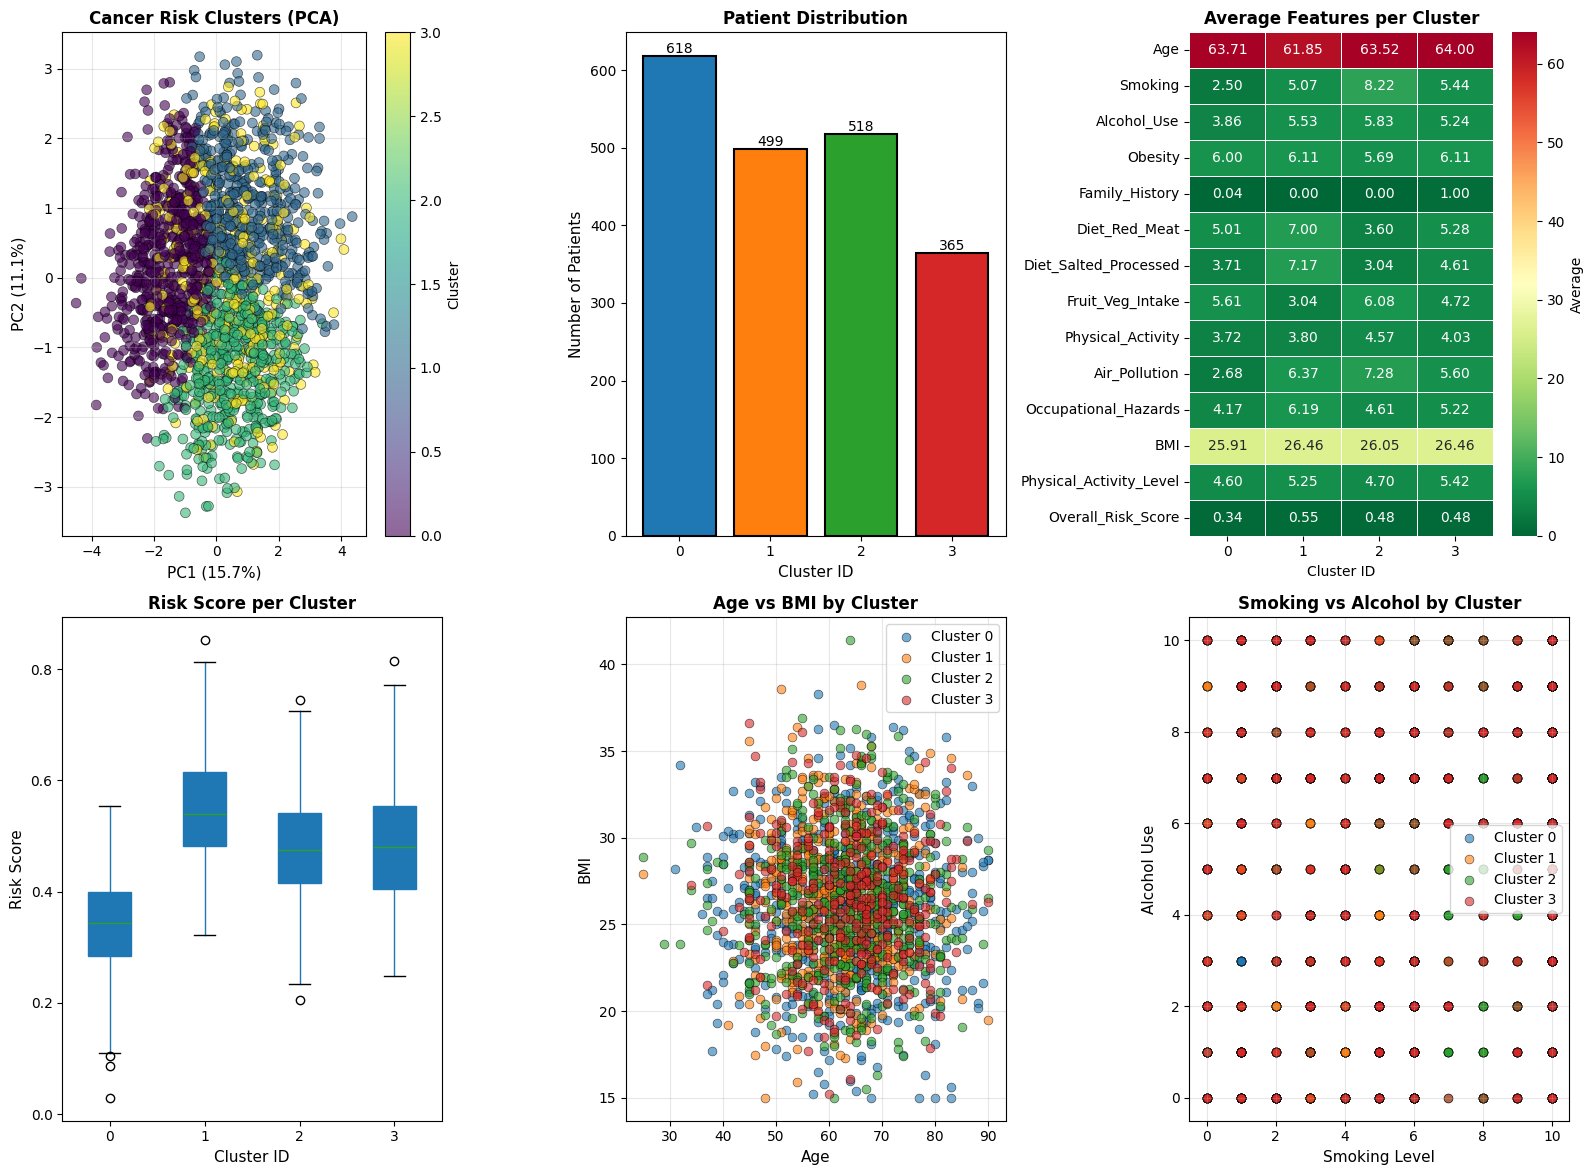

In [8]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Cluster visualization using PCA
plt.subplot(2, 3, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
plt.title('Cancer Risk Clusters (PCA)', fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# 2. Cluster distribution
plt.subplot(2, 3, 2)
cluster_counts = df['Cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index, cluster_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:optimal_k],
               edgecolor='black', linewidth=1.5)
plt.xlabel('Cluster ID', fontsize=11)
plt.ylabel('Number of Patients', fontsize=11)
plt.title('Patient Distribution', fontweight='bold')
plt.xticks(range(optimal_k))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 3. Feature heatmap per cluster
plt.subplot(2, 3, 3)
cluster_means = df.groupby('Cluster')[features].mean()
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Average'}, linewidths=0.5)
plt.title('Average Features per Cluster', fontweight='bold')
plt.xlabel('Cluster ID')

# 4. Risk score distribution
plt.subplot(2, 3, 4)
df.boxplot(column='Overall_Risk_Score', by='Cluster', ax=plt.gca(),
           patch_artist=True, grid=False)
plt.xlabel('Cluster ID', fontsize=11)
plt.ylabel('Risk Score', fontsize=11)
plt.title('Risk Score per Cluster', fontweight='bold')
plt.suptitle('')

# 5. Age vs BMI by cluster
plt.subplot(2, 3, 5)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Age'], cluster_data['BMI'],
               label=f'Cluster {cluster}', alpha=0.6, s=40,
               edgecolors='black', linewidth=0.5)
plt.xlabel('Age', fontsize=11)
plt.ylabel('BMI', fontsize=11)
plt.title('Age vs BMI by Cluster', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Smoking vs Alcohol by cluster
plt.subplot(2, 3, 6)
for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Smoking'], cluster_data['Alcohol_Use'],
               label=f'Cluster {cluster}', alpha=0.6, s=40,
               edgecolors='black', linewidth=0.5)
plt.xlabel('Smoking Level', fontsize=11)
plt.ylabel('Alcohol Use', fontsize=11)
plt.title('Smoking vs Alcohol by Cluster', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cluster Analysis

In [9]:
# Print detailed cluster statistics
print("="*70)
print("CLUSTER STATISTICS")
print("="*70)

for cluster in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster} (n={len(cluster_data)} patients):")
    print(f"  • Avg Risk Score: {cluster_data['Overall_Risk_Score'].mean():.3f}")
    print(f"  • Avg Age: {cluster_data['Age'].mean():.1f} years")
    print(f"  • Avg BMI: {cluster_data['BMI'].mean():.1f}")
    print(f"  • Avg Smoking: {cluster_data['Smoking'].mean():.1f}/10")
    print(f"  • Avg Alcohol: {cluster_data['Alcohol_Use'].mean():.1f}/10")
    print(f"  • Most common cancer: {cluster_data['Cancer_Type'].mode()[0]}")
    
    risk_dist = cluster_data['Risk_Level'].value_counts()
    print(f"  • Risk levels: {dict(risk_dist)}")

CLUSTER STATISTICS

Cluster 0 (n=618 patients):
  • Avg Risk Score: 0.340
  • Avg Age: 63.7 years
  • Avg BMI: 25.9
  • Avg Smoking: 2.5/10
  • Avg Alcohol: 3.9/10
  • Most common cancer: Breast
  • Risk levels: {'Medium': np.int64(341), 'Low': np.int64(277)}

Cluster 1 (n=499 patients):
  • Avg Risk Score: 0.550
  • Avg Age: 61.8 years
  • Avg BMI: 26.5
  • Avg Smoking: 5.1/10
  • Avg Alcohol: 5.5/10
  • Most common cancer: Colon
  • Risk levels: {'Medium': np.int64(432), 'High': np.int64(65), 'Low': np.int64(2)}

Cluster 2 (n=518 patients):
  • Avg Risk Score: 0.479
  • Avg Age: 63.5 years
  • Avg BMI: 26.1
  • Avg Smoking: 8.2/10
  • Avg Alcohol: 5.8/10
  • Most common cancer: Lung
  • Risk levels: {'Medium': np.int64(478), 'Low': np.int64(24), 'High': np.int64(16)}

Cluster 3 (n=365 patients):
  • Avg Risk Score: 0.484
  • Avg Age: 64.0 years
  • Avg BMI: 26.5
  • Avg Smoking: 5.4/10
  • Avg Alcohol: 5.2/10
  • Most common cancer: Lung
  • Risk levels: {'Medium': np.int64(323), 'Hi

In [10]:
# Show sample patients from each cluster
for cluster in range(optimal_k):
    print(f"\n--- Sample from Cluster {cluster} ---")
    print(df[df['Cluster'] == cluster][['Age', 'Cancer_Type', 'Smoking', 
                                         'BMI', 'Overall_Risk_Score']].head(3))


--- Sample from Cluster 0 ---
    Age Cancer_Type  Smoking   BMI  Overall_Risk_Score
3    61       Colon        6  32.1            0.318449
28   67       Colon        5  23.6            0.360223
33   76    Prostate        8  21.8            0.333549

--- Sample from Cluster 1 ---
    Age Cancer_Type  Smoking   BMI  Overall_Risk_Score
6    59        Lung       10  32.3            0.662354
12   55        Skin        9  27.0            0.644230
19   58      Breast        2  20.4            0.529895

--- Sample from Cluster 2 ---
   Age Cancer_Type  Smoking   BMI  Overall_Risk_Score
0   68      Breast        7  28.0            0.398696
1   74    Prostate        8  25.4            0.424299
2   55        Skin        7  28.6            0.605082

--- Sample from Cluster 3 ---
    Age Cancer_Type  Smoking   BMI  Overall_Risk_Score
7    74    Prostate        8  29.1            0.479367
10   63        Lung       10  24.1            0.494523
21   71        Lung       10  25.1            0.546737
